In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os, shutil
import random
from pathlib import Path

# Paths
base_dir = '/content/drive/MyDrive/Chicken_Duck_Dataset'
chicken_src = os.path.join(base_dir, 'chicken-images')
duck_src = os.path.join(base_dir, 'duck-images')

target_base = '/content/Chicken_Duck_Split'
train_chicken = os.path.join(target_base, 'train/chicken')
val_chicken = os.path.join(target_base, 'val/chicken')
train_duck = os.path.join(target_base, 'train/duck')
val_duck = os.path.join(target_base, 'val/duck')

# Create dirs
for path in [train_chicken, val_chicken, train_duck, val_duck]:
    os.makedirs(path, exist_ok=True)

# Split function
def split_and_copy(src_dir, train_dir, val_dir, split_ratio=0.8):
    files = os.listdir(src_dir)
    random.shuffle(files)
    split_idx = int(len(files) * split_ratio)
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dir, f))
    for f in val_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(val_dir, f))

split_and_copy(chicken_src, train_chicken, val_chicken)
split_and_copy(duck_src, train_duck, val_duck)

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(target_base, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(target_base, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 605 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6244 - loss: 0.6782 - val_accuracy: 0.8618 - val_loss: 0.4362
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8919 - loss: 0.3528 - val_accuracy: 0.9211 - val_loss: 0.2765
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9261 - loss: 0.2402 - val_accuracy: 0.9276 - val_loss: 0.2101
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9291 - loss: 0.1969 - val_accuracy: 0.9276 - val_loss: 0.1695
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9584 - loss: 0.1447 - val_accuracy: 0.9342 - val_loss: 0.1544


In [12]:
from sklearn.metrics import classification_report
import numpy as np

val_generator.reset()
preds = model.predict(val_generator)
pred_labels = (preds > 0.5).astype(int)
true_labels = val_generator.classes

print(classification_report(true_labels, pred_labels, target_names=['chicken', 'duck']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
              precision    recall  f1-score   support

     chicken       0.95      0.93      0.94        90
        duck       0.91      0.94      0.92        62

    accuracy                           0.93       152
   macro avg       0.93      0.93      0.93       152
weighted avg       0.93      0.93      0.93       152



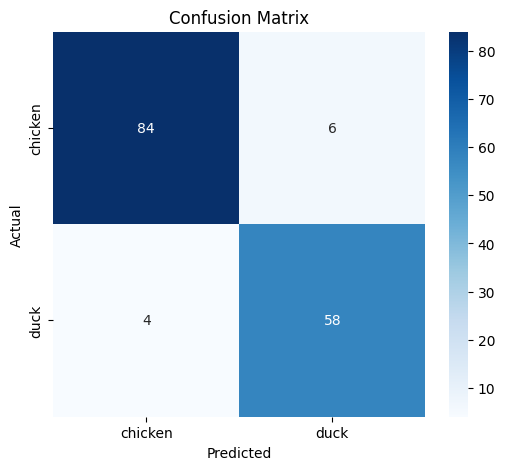

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['chicken', 'duck'], yticklabels=['chicken', 'duck'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()